In [1]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import seaborn as sns
import dateparser

In [2]:
def collect_urls(query: str, max_results: int=100):
    q = f"{query} site:informburo.kz"
    results = list(search(q, num_results=max_results))
    urls = [u for u in results if "informburo.kz" in u]
    return urls[:max_results]

urls = collect_urls("Фонд Булата Утемуратова", max_results=10)
len(urls)

10

In [3]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/114.0.0.0 Safari/537.36")

from selenium.webdriver.chrome.service import Service

service = Service(ChromeDriverManager().install())
driver  = webdriver.Chrome(service=service, options=options)

In [4]:
import time
from bs4 import BeautifulSoup

def parse_article_selenium(url: str):
    driver.get(url)
    time.sleep(2)  

    soup = BeautifulSoup(driver.page_source, "html.parser")

    title_el = soup.select_one("h1.head-single") or soup.select_one("h1.article__title") or soup.select_one("title")
    title = title_el.get_text(strip=True) if title_el else None

    date_el = soup.select_one("div.article-meta time[datetime]")
    date = date_el.get_text(strip=True) if date_el else None

    meta_smalls = soup.select("div.article-meta small.uk-text-muted")
    views = None
    if len(meta_smalls) > 1:
        views = meta_smalls[1].get_text(strip=True)
    return {"url": url, "title": title, "date": date, "views": views}

In [5]:
urls = collect_urls("Фонд Булата Утемуратова", max_results=100)
data = [parse_article_selenium(u) for u in urls]
df = pd.DataFrame(data)
df.head(5)

,url,title,date,views
0,https://informburo.kz/novosti/fond-bulata-utem...,Фонд Булата Утемуратова выделил 680 млн тенге ...,"1 апреля 2024, 12:16",930
1,https://informburo.kz/novosti/fond-bulata-utem...,Фонд Булата Утемуратова построит новую школу в...,"11 мая 2022, 11:01",3342
2,https://informburo.kz/novosti/fond-bulata-utem...,Фонд Булата Утемуратова начал оформление жилья...,"6 мая 2024, 10:00",1320
3,https://informburo.kz/novosti/fond-bulata-utem...,Фонд Булата Утемуратова получил премию Америка...,"3 июня 2024, 15:28",490
4,https://informburo.kz/novosti/bulat-utemuratov...,Булат Утемуратов признан меценатом года - info...,"8 декабря 2023, 11:17",1823


In [6]:
df.to_csv("informburo_articles.csv", index=False)
print("Saved to informburo_articles.csv")

Saved to informburo_articles.csv


In [7]:
import dateparser
import pandas as pd

def parse_ru_date(x):
    if isinstance(x, str):
        return dateparser.parse(x, languages=['ru'])
    return pd.NaT

df['date'] = df['date'].apply(parse_ru_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0).astype(int)

df.dtypes

/var/folders/3m/ygq196c16zs4wgq2yzkj4m200000gn/T/ipykernel_11308/88715954.py:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  return dateparser.parse(x, languages=['ru'])


url              object
title            object
date     datetime64[ns]
views             int64
dtype: object

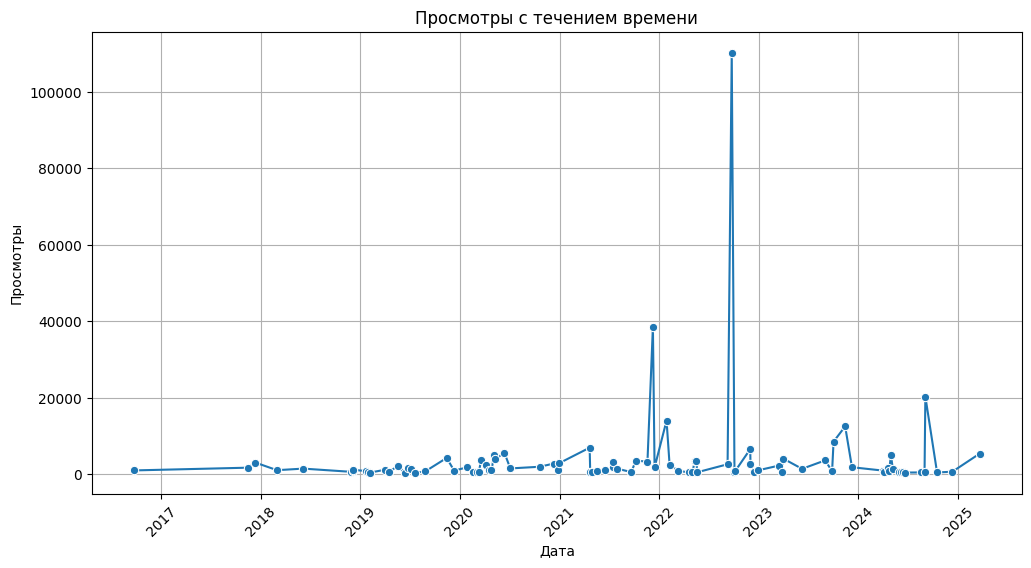

In [12]:
df_sorted = df.sort_values("date")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x="date", y="views", marker="o")
plt.grid(True)
plt.title("Просмотры с течением времени")
plt.xlabel("Дата")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.show()

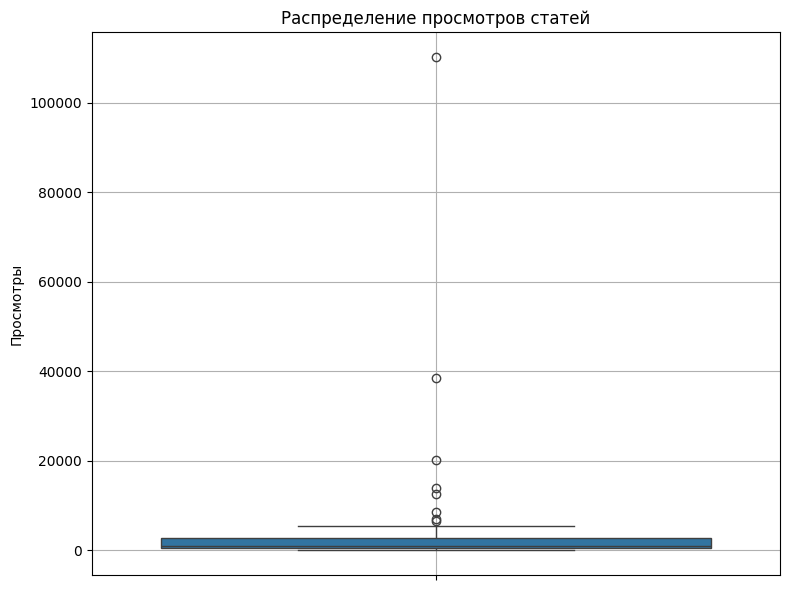

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['views'])
plt.title("Распределение просмотров статей")
plt.ylabel("Просмотры")
plt.tight_layout()
plt.grid(True)
plt.show()

In [10]:
pd.set_option('display.max_colwidth', None)
Q1    = df['views'].quantile(0.25)
Q3    = df['views'].quantile(0.75)
IQR   = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['views'] < lower) | (df['views'] > upper)]
print(f"Number of outliers:{len(outliers)}")
outliers[['title','views']]

Number of outliers:8


,title,views
11,"""Верный Капитал"" и Фонд Булата Утемуратова подарили современную школу ученикам Есика: состоялась первая торжественная линейка - informburo.kz",20299
13,Школьные теплицы и строительство нового терминала аэропорта: Фонд Булата Утемуратова подвёл итоги года - informburo.kz,38573
35,4000 продуктовых корзин от Фонда Булата Утемуратова раздадут малообеспеченным семьям в четырёх городах Казахстана - informburo.kz,6935
55,Как американец с аутизмом стал всемирно известным профессором и что он посоветовал казахстанцам - informburo.kz,6556
60,"Булат Утемуратов перечислил 10 млрд тенге в фонд ""Қазақстан халқына"" - informburo.kz",14020
61,В Косшы начали строительство общественного культурно-спортивного центра - informburo.kz,12513
77,"""Мир один для всех"": много ли в Казахстане детей с аутизмом и как им можно помочь - informburo.kz",8506
98,Почему в Казахстане растёт число детей с аутизмом - informburo.kz,110235


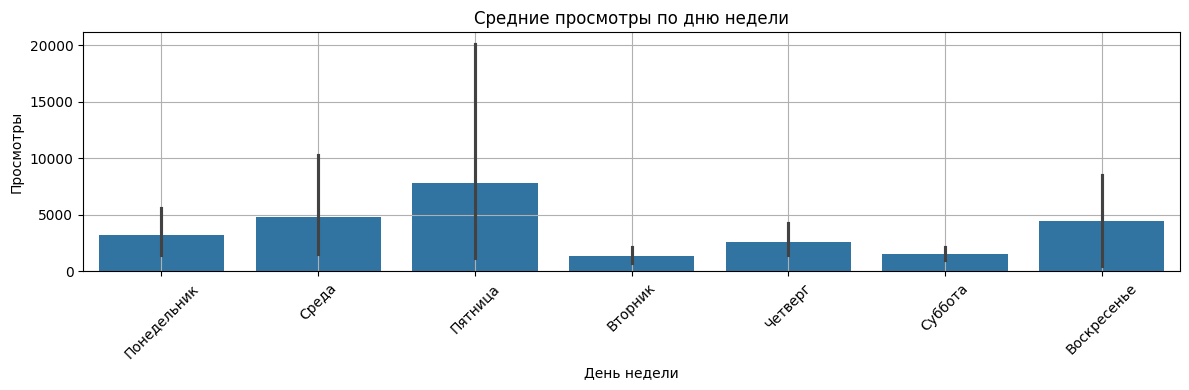

In [11]:
df['dow'] = df['date'].dt.day_name(locale='ru_RU')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=df,
    x='dow',
    y='views',
    estimator='mean', 
)
plt.title("Средние просмотры по дню недели")
plt.xlabel("День недели")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()